<a href="https://colab.research.google.com/github/prabuilangovan/ML-Projects/blob/main/Resume_Classification_Using_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resume Classification using Naive Bayes

## Objectives

To be able to :

* perform data preprocessing, EDA and feature extraction on the Resume dataset
* perform multinomial Naive Bayes classification on the Resume dataset

### Dataset description

The data is in CSV format, with two features: Category, and Resume.

**Category** -  Industry sector to which the resume belongs to, and

**Resume** - The complete CV (text) of the candidate.

## Information

Companies often receive thousands of resumes for each job posting and employ dedicated screening officers to screen qualified candidates. Finding suitable candidates for an open role from a database of 1000s of resumes can be a tough task. Automated resume categorization can speeden the candidate selection process. Such automation can really ease the tedious process of fair screening and shortlisting the right candidates and aid quick decisionmaking.

To learn more about this, click [here](https://www.sciencedirect.com/science/article/pii/S187705092030750X).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.gridspec import GridSpec
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Downloading the data

In [2]:
#@title Download the data
!wget -qq <>/UpdatedResumeDataSet.csv

** Read the UpdatedResumeDataset.csv dataset **

**Hint:** pd.read_csv()

In [3]:
df = pd.read_csv('UpdatedResumeDataSet.csv', encoding='utf-8')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


### Pre-processing and EDA

**Display  all the categories of resumes and their counts in the dataset **



In [6]:
# Displaying the distinct categories of resume
print(df['Category'].unique())

['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [5]:
# Displaying the distinct categories of resume and the number of records belonging to each category
print(df['Category'].value_counts())

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64


**Create the count plot of different categories **

**Hint:** Use `sns.countplot()`

<Axes: xlabel='count', ylabel='Category'>

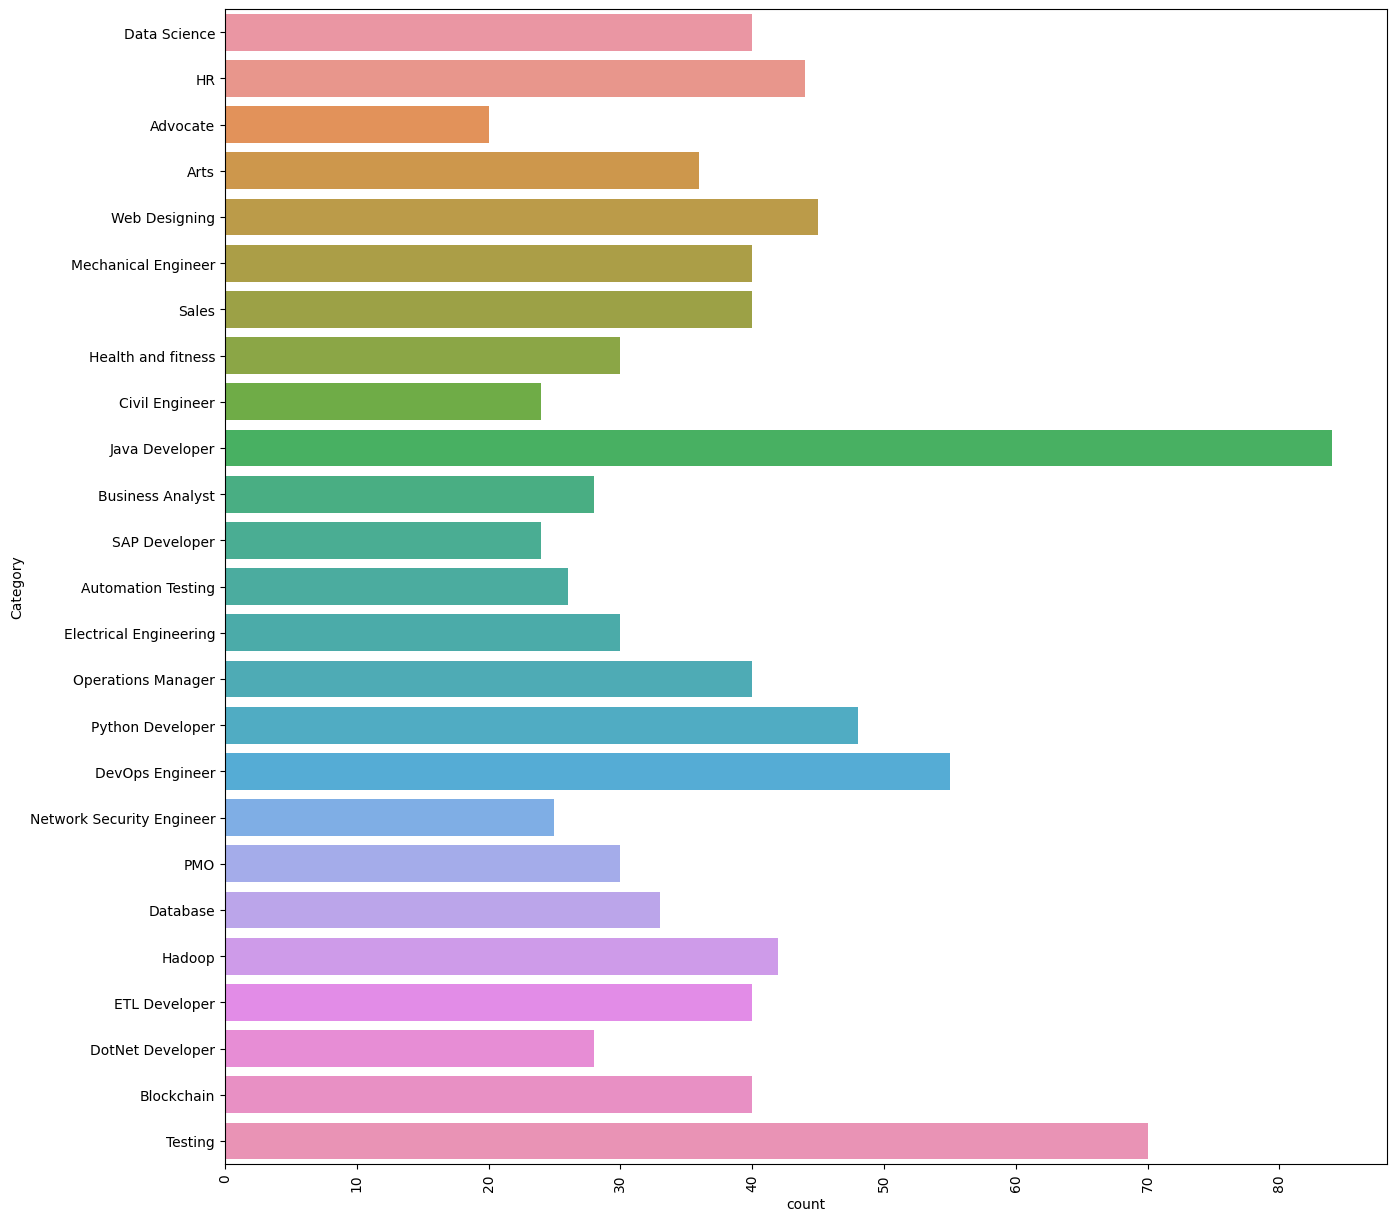

In [7]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=df)

**Create a pie plot depicting the percentage of resume distributions category-wise**

**Hint:** Use [plt.pie()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html) and [plt.get_cmap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for color mapping the pie chart.

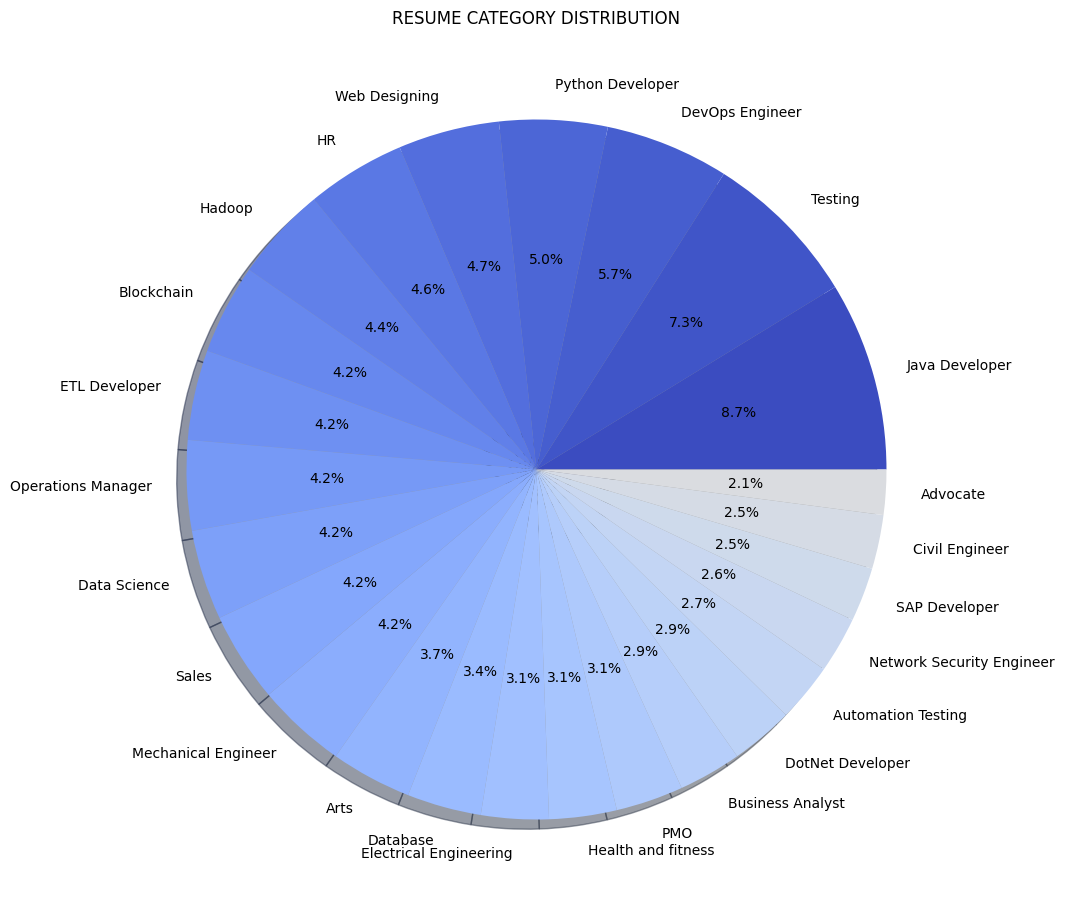

In [8]:
targetCounts = df['Category'].value_counts()
targetLabels  = targetCounts.index
# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1)]
plt.subplot(the_grid[0, 1], aspect=1, title='RESUME CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

**Convert all the `Resume` text to lower case **




In [9]:
# Convert all characters to lowercase
df['Resume']=df['Resume'].str.lower()
print(df['Resume'])

0      skills * programming languages: python (pandas...
1      education details \r\nmay 2013 to may 2017 b.e...
2      areas of interest deep learning, control syste...
3      skills â¢ r â¢ python â¢ sap hana â¢ table...
4      education details \r\n mca   ymcaust,  faridab...
                             ...                        
957    computer skills: â¢ proficient in ms office (...
958    â willingness to accept the challenges. â ...
959    personal skills â¢ quick learner, â¢ eagerne...
960    computer skills & software knowledge ms-power ...
961    skill set os windows xp/7/8/8.1/10 database my...
Name: Resume, Length: 962, dtype: object


### Cleaning Resume

**EDefine a function to clean the resume text **

In the text there are special characters, urls, hashtags, mentions, etc. You need to remove for the following:  

* URLs: For reference click [here](https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python)
* RT | cc: For reference click [here](https://www.machinelearningplus.com/python/python-regex-tutorial-examples/)
* Hashtags, # and Mentions, @
* punctuations
* extra whitespace

PS: Use the provided reference similarly for removing any other such elements.

After cleaning as above, store the Resume Text in a separate column (New Feature).


In [10]:
import re
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText)
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText

In [11]:
df['cleaned_resume'] = df['Resume'].apply(lambda x: cleanResume(x))
print(df['cleaned_resume'][31])

education details may 2013 to may 2017 b e uit rgpv data scientist data scientist matelabs skill details python exprience less than 1 year months statsmodels exprience 12 months aws exprience less than 1 year months machine learning exprience less than 1 year months sklearn exprience less than 1 year months scipy exprience less than 1 year months keras exprience less than 1 year monthscompany details company matelabs description ml platform for business professionals dummies and enthusiasts 60 a koramangala 5th block achievements tasks behind sukh sagar bengaluru india developed and deployed auto preprocessing steps of machine learning mainly missing value treatment outlier detection encoding scaling feature selection and dimensionality reduction deployed automated classification and regression model linkedin com in aditya rathore b4600b146 reasearch and deployed the time series forecasting model arima sarimax holt winter and prophet worked on meta feature extracting problem github com

In [12]:
df.head()    # data after cleaning the resume

,Category,Resume,cleaned_resume
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 b e uit...
2,Data Science,"areas of interest deep learning, control syste...",areas of interest deep learning control system...
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana sql ...
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...


In [13]:
sent_lens = []
for i in df.cleaned_resume:
    length = len(i.split())
    sent_lens.append(length)

print(len(sent_lens))
print(max(sent_lens))

962
2062


In [14]:
df["Resume"][100] ,  df["cleaned_resume"][100]

('skills: natural languages: proficient in english, hindi and marathi. computer skills: proficient with ms-office, internet operation.education details \r\njanuary 2015 to january 2018 llb law mumbai, maharashtra mumbai university\r\njanuary 2015 b.m.m  mumbai, maharashtra s.k.somaiya college, mumbai university\r\n h.s.c   asmita girls junior college, maharashtra board\r\n s.s.c vidya bhawan  maharashtra board\r\nadvocate \r\n\r\nllb student and journalist\r\nskill details \r\ncompany details \r\ncompany - criminal lawyer (law firm)\r\ndescription - ',
 'skills natural languages proficient in english hindi and marathi computer skills proficient with ms office internet operation education details january 2015 to january 2018 llb law mumbai maharashtra mumbai university january 2015 b m m mumbai maharashtra s k somaiya college mumbai university h s c asmita girls junior college maharashtra board s s c vidya bhawan maharashtra board advocate llb student and journalist skill details compan

### Stop Words Removal

The stop words, for example, `and, the, was, and so forth` etc. appear very frequently in the text and are not helpful in the predictive process. Therefore these are usually removed for text analytics and text classification purposes.

1. Tokenize the input words into individual tokens and store it in an array
2. Using `nltk.corpus.stopwords`, remove the stopwords

Hint: See Assignment 'Text Classification using Naive Bayes'


**Use `nltk` package to find the most common words from the `cleaned resume` column**

**Hint:**
* Use `nltk.FreqDist`


In [15]:
# stop words
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
oneSetOfStopWords

{"''",
 '``',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over

In [16]:
# most common words
totalWords =[]
Sentences = df['cleaned_resume'].values
cleanedSentences = ""
for i in range(0,160):
    cleanedText = cleanResume(Sentences[i])
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)

wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

[('details', 488), ('exprience', 446), ('data', 416), ('company', 398), ('months', 394), ('description', 358), ('1', 290), ('project', 254), ('year', 252), ('january', 216), ('learning', 210), ('science', 208), ('less', 204), ('skill', 190), ('python', 176), ('maharashtra', 166), ('6', 164), ('machine', 156), ('education', 146), ('college', 146), ('arts', 144), ('university', 140), ('skills', 134), ('development', 134), ('web', 134), ('like', 126), ('analytics', 120), ('india', 120), ('management', 120), ('application', 120), ('team', 116), ('software', 116), ('using', 110), ('business', 108), ('sql', 104), ('developed', 104), ('monthscompany', 102), ('time', 100), ('used', 98), ('b', 98), ('c', 98), ('experience', 96), ('mumbai', 96), ('projects', 94), ('knowledge', 94), ('analysis', 92), ('technologies', 92), ('hr', 92), ('engineering', 90), ('pune', 90)]


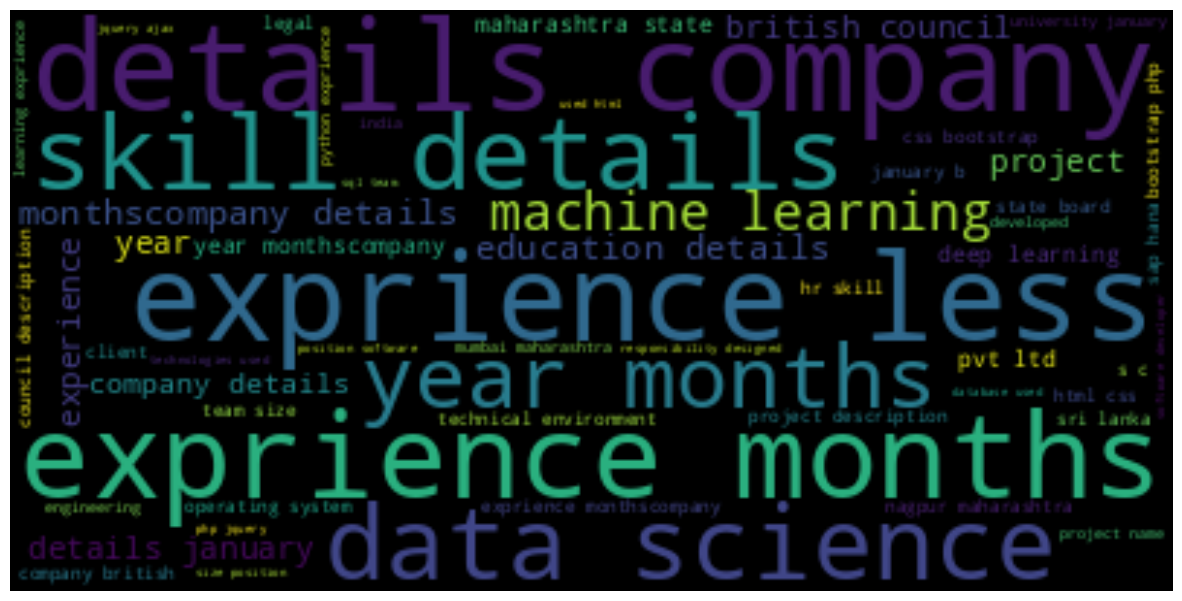

In [17]:
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**Convert the categorical variable `Category` to a numerical feature and make a different column, which can be treated as the target variable **

**Hint:** Use [`sklearn.preprocessing.LabelEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) method

In [18]:
labelencoder = LabelEncoder()
df["Category_Labelled"] = labelencoder.fit_transform(df["Category"])
# print(type(labels))

df.head()

,Category,Resume,cleaned_resume,Category_Labelled
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...,6
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 b e uit...,6
2,Data Science,"areas of interest deep learning, control syste...",areas of interest deep learning control system...,6
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana sql ...,6
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...,6


### Feature Extraction

**Convert the text to feature vectors by applying `tfidf vectorizer` to the Label encoded category made above**

`TF-IDF`will tokenize documents, learn the vocabulary, inverse document frequency weightings, and allow you to encode new documents

**Hint:** Use [`TfidfVectorizer()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).



In [19]:
Text = df['cleaned_resume'].values
op_labels = df['Category_Labelled'].values
word_vectorizer = TfidfVectorizer(max_features = 1500)
word_vectorizer.fit(Text)
features = word_vectorizer.transform(Text)

In [21]:
word_vectorizer.get_feature_names_out()

array(['01', '07', '10', ..., 'xp', 'year', 'years'], dtype=object)

## Naive Bayes Classifier

**Split the data into train and test sets. Apply Naive Bayes Classifier (MultinomialNB)**

**Hint:** Use Vectorized features made above as X and Labelled category as y.

In [23]:
X_train,X_test,y_train,y_test = train_test_split(features,op_labels,random_state=0, test_size=0.2)

In [25]:
clf = MultinomialNB()

In [26]:
clf.fit(X_train, y_train)

MultinomialNB()

In [27]:
print('Accuracy of NaiveBayes Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))

Accuracy of NaiveBayes Classifier on training set: 0.96


In [28]:
pred = clf.predict(X_test)

In [29]:
print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, pred)))


 Classification report for classifier MultinomialNB():
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.75      1.00      0.86         3
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      0.83      0.91         6
           5       1.00      1.00      1.00         5
           6       1.00      0.78      0.88         9
           7       1.00      1.00      1.00         7
           8       1.00      0.91      0.95        11
           9       1.00      0.44      0.62         9
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00         7
          15       0.68      1.00      0.81        19
          16       1.00  

**Analysis**
- Which method(s), other than TF-IDF could be used for text to vector conversion?
- Have a look at the  `alpha`, `class_prior` and `fit_prior` parameters in sklearn `MultinomialNB`
